***Note: this is the Cooperative.ipynb notebook. The
PDF version "Cooperative Enzyme-catalysed Reactions"
is available [here](Cooperative.pdf).***

# Introduction
"For many enzymes, the reaction velocity is not a simple hyperbolic curve, as predicted
by the Michaelis–Menten model, but often has a sigmoidal character. This can result from cooperative effects, in which the enzyme can bind more than one substrate
molecule but the binding of one substrate molecule affects the binding of subsequent
ones" <cite data-cite="KeeSne09">(Keener and Sneyd, 2009)</cite>, Section 1.4.4.

This note gives a bond graph <cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite> interpretation of such cooperativity and uses the iterative properties of [BondGraphTools](https://pypi.org/project/BondGraphTools/) <cite data-cite="CudGawPanCra19X">(Cudmore et. al., 2019)</cite> to build high-order cooperative systems. These systems are simulated to give steady-state behavior as the order of cooperativity increases.



## Import some python code
The bond graph analysis uses a number of Python modules:

In [1]:
## Some useful imports

import BondGraphTools as bgt
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import IPython.display as disp

## Stoichiometric analysis
import stoich as st

## SVG bg representation conversion
import svgBondGraph as sbg

## Modular bond graphs
import modularBondGraph as mbg

## Data structure copy
import copy

## Set quiet=False for verbose output
quiet = True

# Enzyme-catalysed reaction
The basic enzyme-catalysed reaction is given in this section. It is the basic building block of cooperative enzyme-catalysed reactions
More details are given by <cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite>.


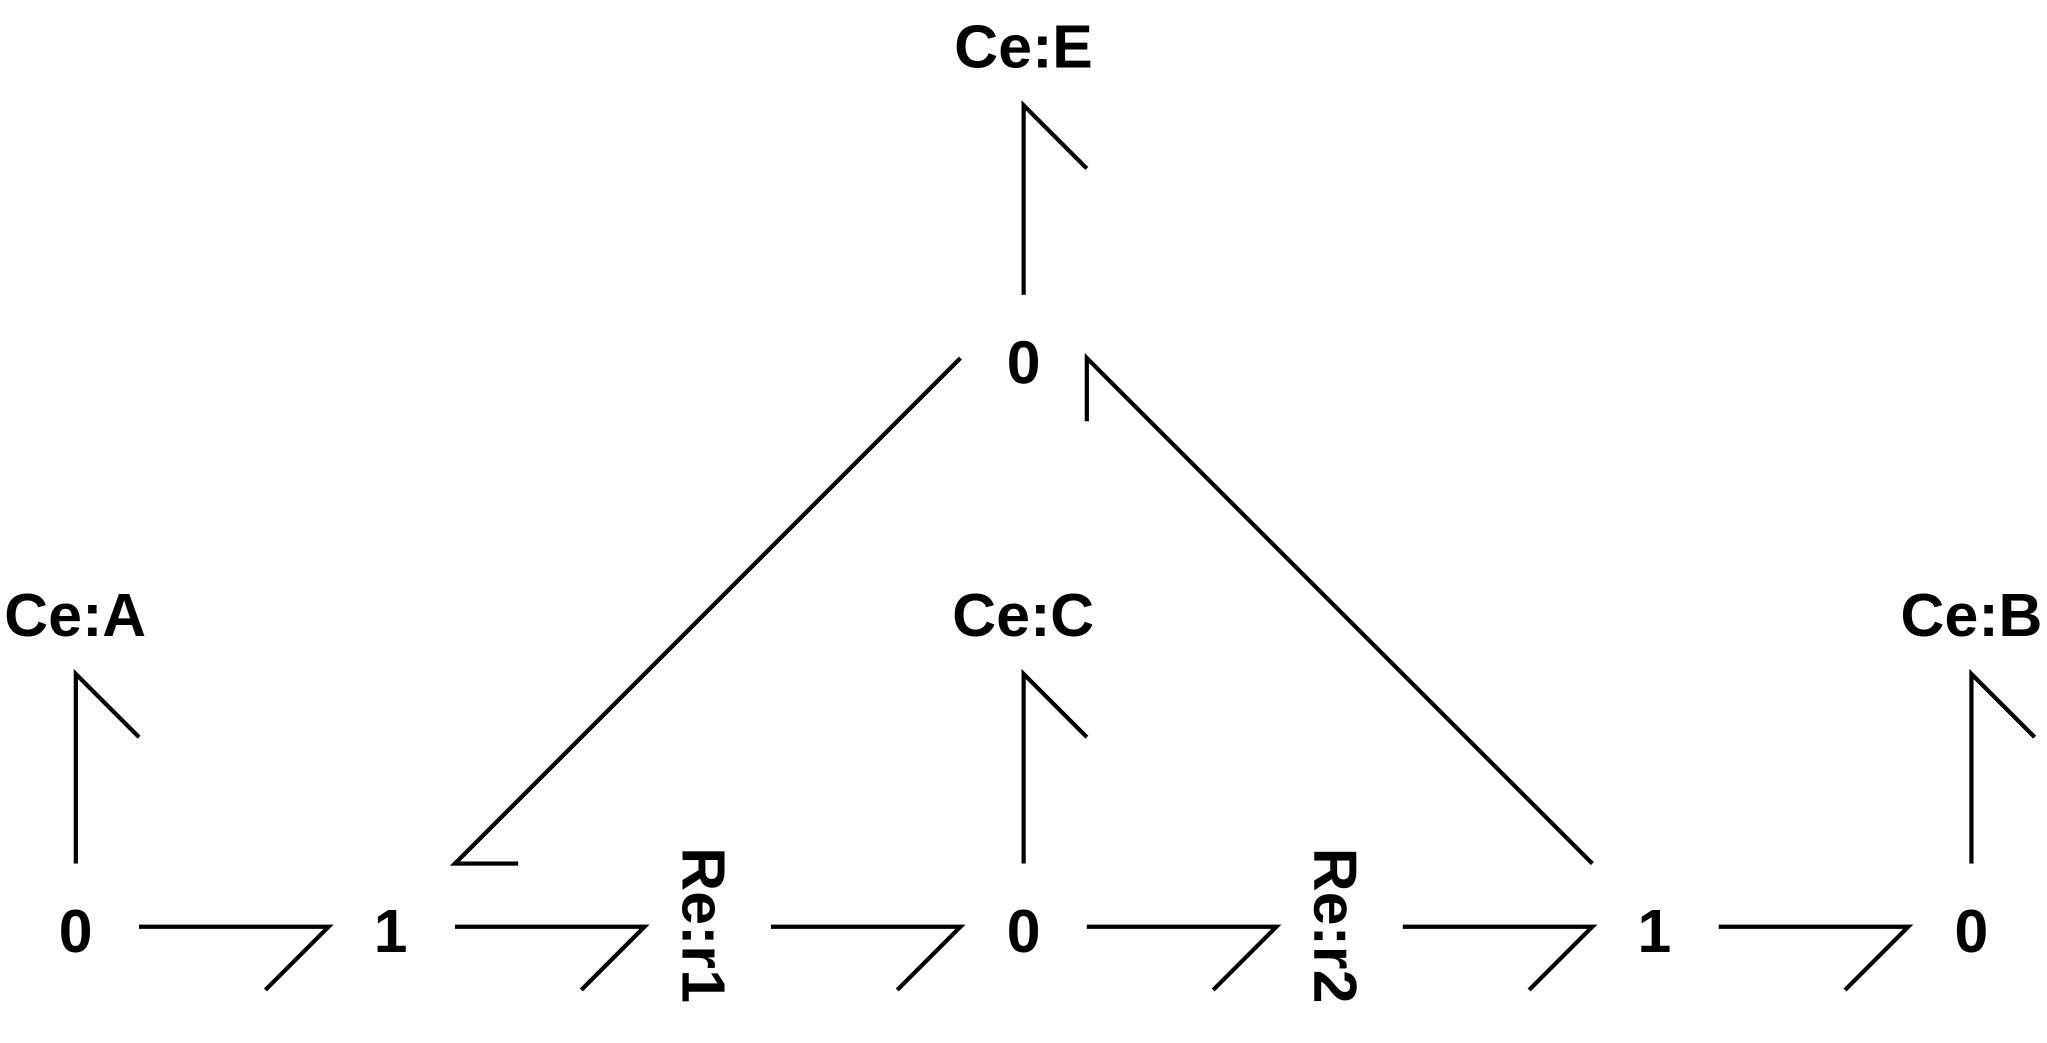

In [2]:
## Enzyme-catalysed reaction
sbg.model('RE_abg.svg')
import RE_abg
disp.SVG('RE_abg.svg')

In [3]:
s = st.stoich(RE_abg.model(),quiet=quiet)
disp.Latex(st.sprintrl(s,chemformula=True))

<IPython.core.display.Latex object>

# Cooperative enzyme-catalysed reaction

<cite data-cite="KeeSne09">(Keener and Sneyd, 2009)</cite>, Section 1.4.4, discusses cooperativity. This section gives a bond graph interpretation. This is done in two ways:

1. As a graphical representation of a two-stage cooperative enzyme-catalysed reaction.
2. As a generic representation of an N-stage cooperative enzyme-catalysed reaction using  [bond-graph tools](https://pypi.org/project/BondGraphTools/)

## Two-stage cooperative enzyme-catalysed reaction (N=2) <a id='coop2'></a>


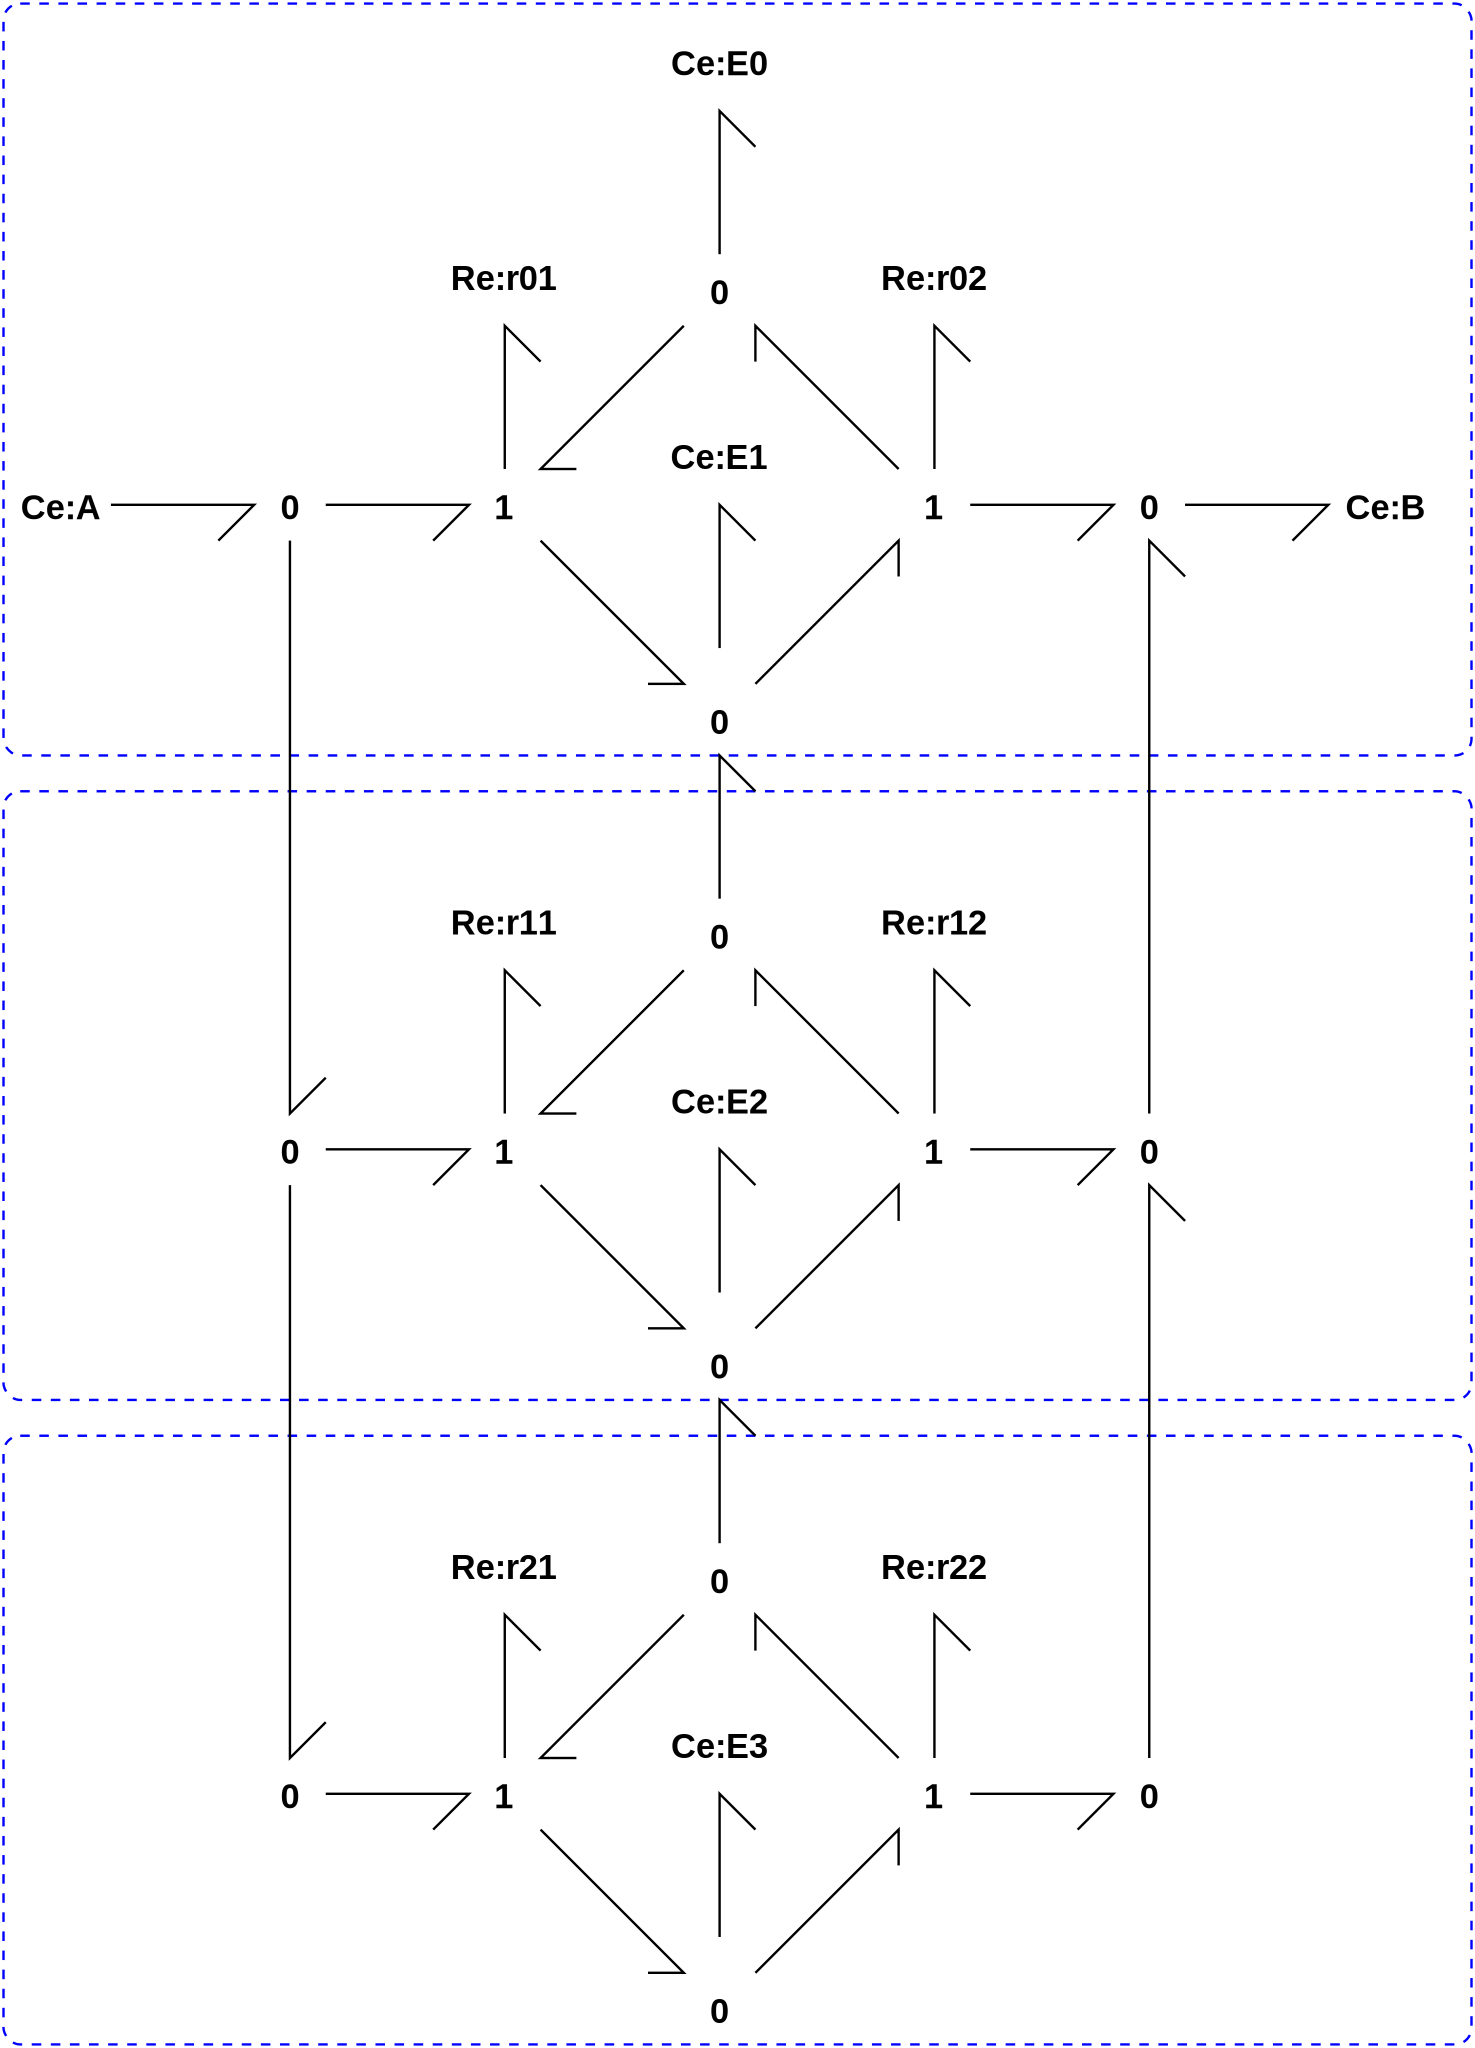

In [4]:
## Two-stage cooperative enzyme-catalysed reaction (N=2)
sbg.model('Coop_abg.svg',quiet=quiet)
import Coop_abg
disp.SVG('Coop_abg.svg')

In [5]:
ss = st.stoich(Coop_abg.model(),quiet=quiet)
ssc = st.statify(ss,chemostats=['A','B'])
disp.Latex(st.sprintrl(ss,chemformula=True))


<IPython.core.display.Latex object>

## Create cooperative enzyme-catalysed reaction of any degree N
The following code builds an N-stage cooperative enzyme-catalysed reaction using  [bond-graph tools](https://pypi.org/project/BondGraphTools/).

1. N+1 instances of the basic enzyme-catalysed reaction are created and the enzyme and complex renamed.
2. The substrate A, product B  and enzymes E1-EN are unified.

In [6]:
## Create cooperative enzyme-catalysed reaction of any degree N
## Optionally append a simple reaction
## Optionally use feedback inhibition
def makeCoop(N=3,quiet=True):
    Coop = bgt.new(name='Coop')
    for i in range(N+1):
        RE = RE_abg.model()
        RE.name = 'RE'+str(i)
        mbg.rename(RE,{
                    'E':'E'+str(i), 
                    'C':'E'+str(i+1),
                    'r1':'r'+str(i)+'1',
                    'r2':'r'+str(i)+'2'
                    },
                   quiet=quiet)
        Coop.add(RE)

    ## Unify common components
    unified = ['A','B']
    for i in range(N): 
        Ei = 'E'+str(i+1)
        unified.append(Ei)
    print('unified =',unified)
    mbg.unify(Coop,unified,quiet=quiet)

        
    ## Stoichiometry
    chemostats = ['A','B']
    s = st.stoich(Coop,quiet=quiet)
    sc = st.statify(s,chemostats=chemostats)
    if not quiet:
        print(st.sprint(sc,'species'))
        print(st.sprint(sc,'reaction'))
    return s,sc,Coop

### Generate equations for $N=2$
Note that these equations are identical to those of the explicit bondgraph.

In [7]:
### Generate equations for N=2
s,sc,Coop = makeCoop(N=2,quiet=quiet)
disp.Latex(st.sprintrl(s,chemformula=True))

unified = ['A', 'B', 'E1', 'E2']


<IPython.core.display.Latex object>

### Generate pathway equations for $N=2$
Pathways are generated using the approach of <cite data-cite="GawCra17">Gawthrop and Crampin (2014)</cite>.

In [8]:
sp = st.path(s,sc)
print(st.sprintp(sc))
disp.Latex(st.sprintrl(sp))

3 pathways
0:  + r01 + r02
1:  + r11 + r12
2:  + r21 + r22



<IPython.core.display.Latex object>

## Steady-state properties

The steady state properties are investigated using dynamic simulation where slowly varing exogenous quantities are used to induce quasi-steady-state behaviour. In each case, the variable is at a constant value to start with followed by a slowly increasing ramp. The response after the initial reponse is plotted to remove artefacts due to the initial transient.

All parameters are unity except for $K_B=0.01$ (to approximate an irreversible reaction) and initial states are chosen so that the total enzyme is $e_0=1$.

### Set up some parameters for simulation

In [9]:
## Set up some parameters for simulation
def setParameter(s,N,e0):
    ## Set up the non-unit parameters and states
    
    K_E0 = 1
    K_EN = 1/K_E0
    K_m = K_EN/K_E0
    parameter = {}

    ## Set product constant to a small value
    ## to make the ECR approximately irreversible
    K_B = 0.01
    parameter['K_B'] = K_B
    
    ## Set up enzyme parameters and reaction constants
    parameter['K_E0'] = K_E0
    parameter['K_E'+str(N+1)] = K_EN
    
    ## States
    ## Set total enzyme to e0
    X0 = np.ones(s['n_X'])
    for i in range(N+2):
        Ei = 'E'+str(i)
        X0[s['spec_index'][Ei]] = (e0/(N+2))     
        
    return parameter,X0,K_EN,K_m

In [10]:
## Compute the total enzyme
def totalE(N,dat,Feedback=False):
    E_spec = []
    for i in range(N+2):
        Ei = 'E'+str(i)
        E_spec.append(Ei)
    
    for spec in E_spec:
        x = copy.copy(dat['X'][:,s['spec_index'][spec]])
        if spec is E_spec[0]:
            X = x
        else:
            X += x
            
    return X
            

In [11]:
## Compute the total flow
def totalFlow(s,N,dat):
    for i in range(N+1):
        r = 'r'+str(i)+'2'
        Vi = copy.copy(dat['V'][:,s['reac_index'][r]])
        if i is 0:
            V = Vi
        else:
            V += Vi
    return V

### Vary substrate concentration  $x_A$

unified = ['A', 'B']
unified = ['A', 'B', 'E1']
unified = ['A', 'B', 'E1', 'E2', 'E3', 'E4', 'E5']


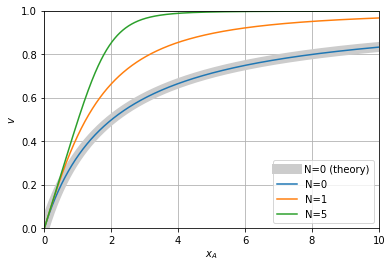

In [12]:
## Simulation
## Vary x_A

##Time
quiet = True
t_max = int(1e4)
t = np.linspace(0,t_max,1000)
t_0 = 100
t_1 = t_max-t_0
i_max = len(t)
i_0 = int(i_max*t_0/t_max)
i_1 = i_max-i_0

NN = [0,1,5]
for N in NN:
    ## Create system stoichiometry
    s,sc,Coop = makeCoop(N=N,quiet=quiet)
    
    ## Non-unit parameters and states
    e0 = 1 # Total enzyme
    parameter,X0,K_EN,K_m = setParameter(s,N,e0)
    K_B = parameter['K_B']

    ## Chemostats: vary x_A
    x_max = 10
    x_min = K_B
    
    A_chemo = '{3} + ({0}-{3})*np.heaviside(t-{1},1)*((t-{1})/{2})'.format(x_max,t_0,t_1,x_min)
    X_chemo =  {'A':A_chemo}
    
    ## Simulate
    dat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=X0,X_chemo=X_chemo,quiet=quiet)
    V = totalFlow(s,N,dat)
    x_A = dat['X'][:,s['spec_index']['A']]
    
    ## Compute approx ECR flow (assumes K_B is small)
    V_ECR = e0*(x_A-K_B)/((2*K_m) + x_A)
    
    if N is NN[0]:
        VV = V
        VV_ECR = V_ECR
    else:
        VV = np.vstack((VV,V))


## Plot flow v. x_A  
grey = '0.8'
plt.clf()
plt.plot(x_A,VV_ECR,color=grey,lw=10)
if len(NN) is 1:
    plt.plot(x_A[-i_1:],VV[-i_1:])
else:
    plt.plot(x_A[-i_1:],VV[:,-i_1:].T)   
plt.grid()
plt.ylim((0,e0))
plt.xlim((0,x_max))
plt.legend(['N=0 (theory)']+['N='+str(i) for i in NN])
plt.xlabel('$x_A$')
plt.ylabel('$v$')
plt.show()


The effect of cooperativity is to give an approximation to a linear rise in $v$ as $x_A$ increases with a cut off at $v=e0=1$.

## A closer look
The following graphs look more closely at the behaviour of the system for N=5. 

1. The first graph shows the $N+1=6$ enzyme/complex states plotted against $x_A$. These states form a conserved moiety and the sum is $e_0$.
2. The second graph shows the $N=5$ reaction flows plotted against $x_A$. In this particular case, $K_B\approx0$ and so the flow though reaction $ri2$ is $v_i \approx \kappa_{ri2} K_{Ei+1} x_{Ei+1} = x_{Ei+1}$.

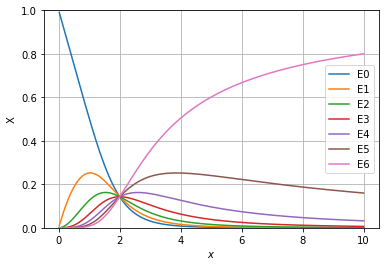

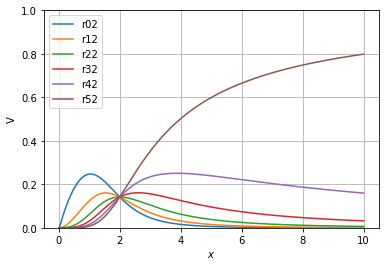

In [13]:
st.plot(s,dat,species=['E'+str(i) for i in range(N+2)],reaction=[],ylim=(0,1),x=x_A,i0=i_0)
st.plot(s,dat,species=[],reaction=['r'+str(i)+'2' for i in range(N+1)],ylim=(0,1),x=x_A,i0=i_0)
